In [2]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as loading_bar
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_helpers

torch.set_default_dtype(torch.float32)


In [3]:
# Importing Data

train_data = pd.read_csv("digit-recognizer/train.csv")
submission_data = pd.read_csv("digit-recognizer/test.csv")

In [4]:
print(f'Training data shape: {train_data.shape}')
print(f'Testing data shape: {submission_data.shape}')

train_x = np.reshape(train_data.iloc[:,1:].to_numpy(np.float32), (-1,1,28,28))
train_y = train_data.iloc[:,0].to_numpy()
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size = 0.1)
train_x, test_x, train_y, test_y = torch.from_numpy(train_x), \
                                   torch.from_numpy(test_x), \
                                   torch.from_numpy(train_y),\
                                   torch.from_numpy(test_y)

submission_x = torch.from_numpy(np.reshape(submission_data.to_numpy(),(-1,1,28,28)))
print(f'Training Data: (Images: {train_x.shape}, Labels: {train_y.shape})')
print(f'Testing Data: (Images: {test_x.shape}, Labels: {test_y.shape})')
print(f'Submission Data: (Images: {submission_x.shape})')

Training data shape: (42000, 785)
Testing data shape: (28000, 784)
Training Data: (Images: torch.Size([37800, 1, 28, 28]), Labels: torch.Size([37800]))
Testing Data: (Images: torch.Size([4200, 1, 28, 28]), Labels: torch.Size([4200]))
Submission Data: (Images: torch.Size([28000, 1, 28, 28]))


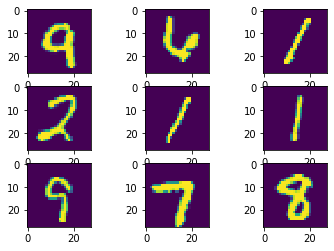

In [5]:
# Sample Images

fig, axes = plt.subplots(3,3)
axes = axes.flatten()
for i in range(9):
    sample_img = train_x[i,0,:,:]
    axes[i].imshow(sample_img)

In [6]:
# Create CNN Class

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer=nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
            ),
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=3,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
            ),
            nn.Flatten(start_dim=1,end_dim=3)
        )
        self.linear_layer=nn.Sequential(
            nn.Linear(
                in_features=784,
                out_features=10,
            ),
        )
        
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer= optim.SGD(self.parameters(),lr=0.01)
        
        self.training_losses = []
        self.testing_losses = []
        
    def forward(self, img):
        # img is 28*28 vector
        return self.linear_layer(self.conv_layer(img))
    
    def learn_weights(self, train_x, train_y, test_x, test_y, epochs):
        self.train()
        sampler = data_helpers.BatchSampler(
            data_helpers.SubsetRandomSampler(range(train_x.shape[0])),
            batch_size=4,
            drop_last=False
        )
        
        for epoch in range(epochs):
            for batch in loading_bar(sampler, desc=f'(Current Epoch: {epoch})'):
                batch_train_x = train_x[batch,:,:,:]
                batch_train_y = train_y[batch]
                
                self.optimizer.zero_grad()
                
                batch_train_pred_y = self.forward(batch_train_x)
                train_loss = self.loss_fn(batch_train_pred_y, batch_train_y)
                
                train_loss.backward()
                self.optimizer.step()
            
            train_pred_y = self.forward(train_x)
            epochal_training_loss = self.loss_fn(train_pred_y, train_y)
            self.training_losses.append(epochal_training_loss)
            
            test_pred_y = self.forward(test_x)
            epochal_testing_loss = self.loss_fn(test_pred_y, test_y)
            self.testing_losses.append(epochal_testing_loss)
                
    def visualize_training(self):
        fig, ax = plt.subplots(nrows=1,ncols=1)
        ax.plot(self.training_losses, label="Training Loss")
        ax.plot(self.testing_losses, label="Testing Loss")
        ax.legend()
        fig.show()
        
    def MAP(self, x):
        with torch.no_grad():
            raw_pred_y = self.forward(x)
        
        categorical_pred_y = np.argmax(torch.exp(raw_pred_y).numpy(), axis=1)
        return categorical_pred_y
    
    def compute_accuracy(self, test_x, test_y):
        return accuracy_score(self.MAP(test_x), test_y)
            
    

In [ ]:
# Train model

model = CNN()
model.learn_weights(train_x, train_y, test_x, test_y, epochs=20)
model.visualize_training()



In [1]:
print(model.training_losses)
    

NameError: name 'model' is not defined

In [49]:
x = torch.Tensor([0,1,2,3,4])
x_1 = torch.exp(x)
print(x_1)
x_2 = list(x_1.numpy())
print(x_2)
x_3 = np.argmax(x_2, axis=0)
print(x_3)

print(accuracy_score([np.argmax(torch.exp(x).numpy())],[4]))


tensor([ 1.0000,  2.7183,  7.3891, 20.0855, 54.5982])
[1.0, 2.7182817, 7.389056, 20.085537, 54.598152]
4
1.0


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


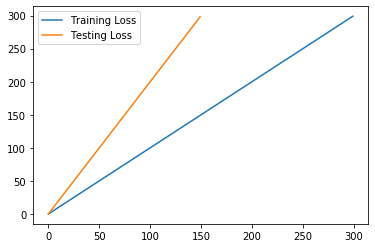

In [36]:
I = [ torch.Tensor([i]) for i in range(300) ]
J = [ torch.Tensor([j]) for j in range(0, 300, 2) ]

fig, ax = plt.subplots(nrows=1,ncols=1)
ax.plot(I, label="Training Loss")
ax.plot(J, label="Testing Loss")
ax.legend()
fig.show()